In [1]:
#Load packages
import sys
import os
import time
import datetime

import numpy as np
import sklearn as sk
import pandas as pd
import tensorflow as tf
import seaborn as sns
import nltk

import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, SimpleRNN, GRU, LSTM, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

from transformers import BertConfig, TFBertModel

%load_ext tensorboard
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 18})

# Package versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sk.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('### TF Keras version: ' + keras.__version__)
print('### Seaborn version: ' + sns.__version__)
print('------------')

C:\Program Files\Anaconda3\envs\cis3\lib\site-packages\torch\package\_directory_reader.py:17: UserWarning: Failed to initialize NumPy: module compiled against API version 0xe but this version of numpy is 0xd (Triggered internally at  C:\Users\builder\tkoch\workspace\pytorch\pytorch_1647970138273\work\torch\csrc\utils\tensor_numpy.cpp:68.)
  _dtype_to_storage = {data_type(0).dtype: data_type for data_type in _storages}


### Python version: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
### Numpy version: 1.19.5
### Scikit-learn version: 0.23.2
### Tensorflow version: 2.6.0
### TF Keras version: 2.6.0
### Seaborn version: 0.11.0
------------


In [2]:
# Set seed
seed = 52
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Load data, select columns, remove NaN
tweets_path = 'Data/tweets.csv'
tweets_df = pd.read_csv(tweets_path,
                          encoding = "ISO-8859-1")
features = ['tweets', 'sentiment']
tweets_df = tweets_df[tweets_df.columns[tweets_df.columns.isin(features)]]
tweets_df = tweets_df.dropna()
tweets_df

,tweets,sentiment
0,#BTC The biggest dump in history is coming,2
1,#BTC How far do you think bitcoin will fall?,2
2,#BTC time to buy,0
3,#BTC its brutal out here,2
4,#BTC going down,2
...,...,...
195,$LRC Anyone know the reason for LRC pumping? I...,0
196,$LRC we need more market cap .sure whales have...,1
197,$APE Beware there is a big dump coming,2
198,What is something you would like to see $APE d...,1


In [4]:
# convert to numpy, split features and target

all_tweets = np.asarray(tweets_df)
all_x = all_tweets[:, 0:1]
#all_y = tf.keras.utils.to_categorical(all_tweets[:, 1:all_tweets.shape[1]], num_classes=3)
#all_y = tf.convert_to_tensor(all_tweets[:, 1:all_tweets.shape[1]])
all_y = all_tweets[:, 1:all_tweets.shape[1]]

all_x.shape, all_y.shape

((200, 1), (200, 1))

In [5]:
#train test val split
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size = .4, random_state = seed)
test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, test_size = .5, random_state = seed)

# verify shapes
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)
print(test_x.shape, val_x.shape, test_y.shape, val_y.shape)
all_tweets

(120, 1) (40, 1) (120, 1) (40, 1)
(40, 1) (40, 1) (40, 1) (40, 1)


array([['#BTC\xa0The biggest dump in history is coming', 2],
       ['#BTC\xa0How far do you think bitcoin will fall?', 2],
       ['#BTC\xa0time to buy', 0],
       ['#BTC\xa0its\xa0brutal\xa0out\xa0here', 2],
       ['#BTC\xa0going down', 2],
       ['I\x92m bullish on$BTC', 0],
       ['#BTC\xa0will only recover next year but this is the right time to accumulate more bitcoin',
        0],
       ['#BTC\xa0Really, even if Bitcoin reaches 100,000 dollars, it is not worth investing because it is completely controlled by the capitalist class. Bitcoin is the biggest scammer of the 21st century.',
        2],
       ['#BTC\xa0im not worry, I love action', 0],
       ['#BTC\xa0Going to liquidate @saylor', 2],
       ['#BTC\xa0buy the bottom dont miss the train you will all invest next Week when its 25k',
        0],
       ['#BTC\xa0buy the bottom', 0],
       ['#BTC\xa0babylon\xa0is\xa0falling\xa0down.\xa0Everybody\xa0losin\xa0control',
        2],
       ['#BTC\xa0when everybody says it 

In [6]:
# dataframe equivalents of splits
train_x_df = pd.DataFrame(train_x)
test_x_df = pd.DataFrame(test_x)
val_x_df = pd.DataFrame(val_x)

In [7]:
# convert y labels to tensors
train_y = tf.convert_to_tensor(np.asarray(train_y).astype('float32'))
test_y = tf.convert_to_tensor(np.asarray(test_y).astype('float32'))
val_y = tf.convert_to_tensor(np.asarray(val_y).astype('float32'))
print(val_y)

tf.Tensor(
[[0.]
 [2.]
 [0.]
 [1.]
 [0.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [1.]
 [1.]
 [2.]
 [1.]
 [1.]
 [1.]
 [2.]
 [1.]
 [0.]
 [0.]
 [1.]], shape=(40, 1), dtype=float32)


In [8]:
def getClassCounts(dataset):
    bullishCount = 0
    neutralCount = 0
    bearishCount = 0
    
    for i in dataset:
        if (i == 0):
            bullishCount = bullishCount + 1
        elif (i == 1):
            neutralCount = neutralCount + 1
        elif (i == 2):
            bearishCount = bearishCount + 1
    return bullishCount, neutralCount, bearishCount

In [9]:
from matplotlib import pyplot as plt
# check 8, 10
bullishTrainSize, neutralTrainSize, bearishTrainSize = getClassCounts(train_y)
bullishTestSize, neutralTestSize, bearishTestSize = getClassCounts(test_y)
bullishValSize, neutralValSize, bearishValSize = getClassCounts(val_y)

<BarContainer object of 3 artists>

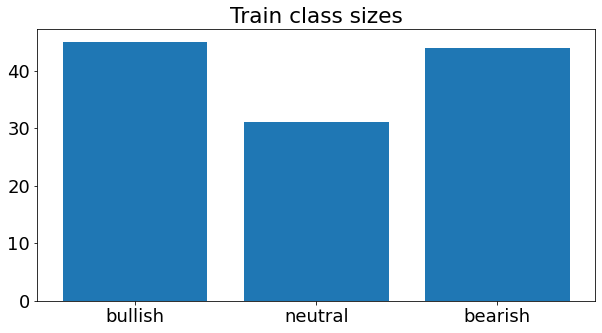

In [10]:
classes = ['bullish', 'neutral', 'bearish']
fig = plt.figure(figsize = (10, 5))
plt.title("Train class sizes")
plt.bar(classes,[bullishTrainSize, neutralTrainSize, bearishTrainSize])

9


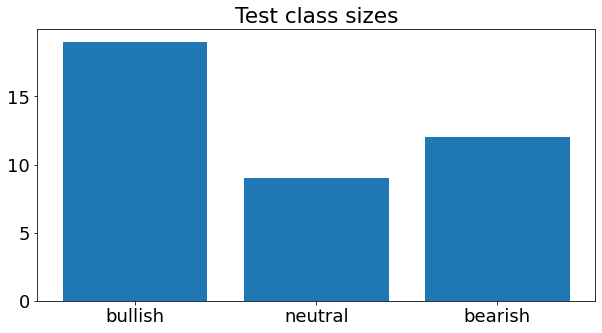

In [83]:
fig = plt.figure(figsize = (10, 5))
plt.title("Test class sizes")
plt.bar(classes,[bullishTestSize, neutralTestSize, bearishTestSize])

<BarContainer object of 3 artists>

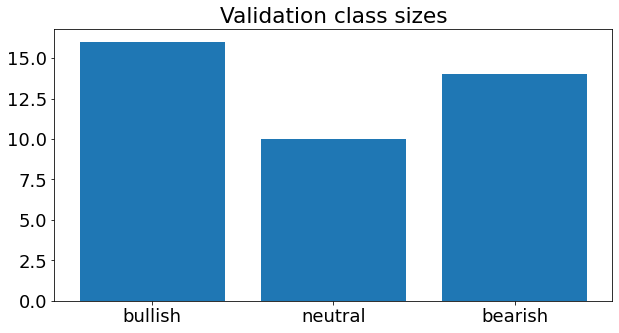

In [12]:
bullishValSize, neutralValSize, bearishValSize
fig = plt.figure(figsize = (10, 5))
plt.title("Validation class sizes")
plt.bar(classes,[bullishValSize, neutralValSize, bearishValSize])

In [13]:
# load model
twitter_model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
loss_function = "sparse_categorical_crossentropy"
opt = keras.optimizers.Adam(learning_rate=1e-5)
twitter_model.compile(loss=loss_function, metrics=['accuracy'], optimizer=opt)

In [15]:
# tokenize data
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
train_tokenized = tokenizer(list(train_x_df[0]), return_tensors="np", padding=True)
test_tokenized = tokenizer(list(test_x_df[0]), return_tensors="np", padding=True)
val_tokenized = tokenizer(list(val_x_df[0]), return_tensors="np", padding=True)

train_tokenized

{'input_ids': array([[  101,   109,   149, ...,     0,     0,     0],
       [  101,   109,   161, ...,     0,     0,     0],
       [  101,   109,   161, ...,     0,     0,     0],
       ...,
       [  101,   108, 27378, ...,     0,     0,     0],
       [  101,   108, 27378, ...,     0,     0,     0],
       [  101,   109, 27269, ...,     0,     0,     0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}

In [16]:
twitter_model.fit(train_tokenized.data, train_y, epochs=9, batch_size=30, validation_data=(val_tokenized.data, val_y))

Epoch 1/9
4/4 [==============================] - 21s 2s/step - loss: 6.9800 - accuracy: 0.3667 - val_loss: 6.7207 - val_accuracy: 0.3500
Epoch 2/9
4/4 [==============================] - 3s 875ms/step - loss: 7.0966 - accuracy: 0.3833 - val_loss: 4.5706 - val_accuracy: 0.2500
Epoch 3/9
4/4 [==============================] - 3s 879ms/step - loss: 5.0127 - accuracy: 0.3167 - val_loss: 1.0091 - val_accuracy: 0.3750
Epoch 4/9
4/4 [==============================] - 3s 880ms/step - loss: 2.2625 - accuracy: 0.2667 - val_loss: 2.1206 - val_accuracy: 0.4000
Epoch 5/9
4/4 [==============================] - 3s 882ms/step - loss: 2.3175 - accuracy: 0.3583 - val_loss: 2.1312 - val_accuracy: 0.4250
Epoch 6/9
4/4 [==============================] - 3s 881ms/step - loss: 1.7795 - accuracy: 0.4000 - val_loss: 1.3038 - val_accuracy: 0.4500
Epoch 7/9
4/4 [==============================] - 3s 885ms/step - loss: 1.5704 - accuracy: 0.4000 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 8/9
4/4 [==============

In [13]:
twitter_model.save_pretrained("55", saved_model=True)

INFO:tensorflow:Assets written to: 55\saved_model\1\assets


INFO:tensorflow:Assets written to: 55\saved_model\1\assets


In [77]:
import math
def evaluate(predictions, true_y):
    count = 0
    counter = 0
    zCounter = 0
    for i in predictions:
        if (i == true_y[counter]):
            count = count + 1
        if (i == true_y[counter] and i == 1):
            zCounter = zCounter + 1
        counter = counter + 1
    print(zCounter)
    return count / true_y.shape[0]

In [78]:
logits = twitter_model.predict(test_tokenized.data)
logits[0].shape

(40, 3)

In [79]:
# make predictions on test dataset and apply softmax
preds = tf.nn.softmax(logits[0])
preds

<tf.Tensor: shape=(40, 3), dtype=float32, numpy=
array([[0.23884101, 0.38176265, 0.37939635],
       [0.4025309 , 0.39003578, 0.20743331],
       [0.39735112, 0.3250558 , 0.2775931 ],
       [0.3699221 , 0.31272843, 0.31734943],
       [0.385642  , 0.30325732, 0.31110075],
       [0.38344577, 0.30618638, 0.31036785],
       [0.39576247, 0.34147763, 0.26275992],
       [0.3878001 , 0.3278946 , 0.28430527],
       [0.36354154, 0.31085598, 0.3256024 ],
       [0.2979317 , 0.3387778 , 0.3632905 ],
       [0.33839437, 0.31431687, 0.34728876],
       [0.37049538, 0.32242292, 0.30708167],
       [0.3833228 , 0.32597306, 0.29070416],
       [0.3725821 , 0.29918128, 0.32823658],
       [0.38838103, 0.33148682, 0.28013217],
       [0.3977295 , 0.3307644 , 0.27150604],
       [0.34809354, 0.32718173, 0.32472473],
       [0.33520666, 0.31760955, 0.3471838 ],
       [0.38614026, 0.30172804, 0.31213173],
       [0.32185918, 0.32451412, 0.3536267 ],
       [0.37308973, 0.31681773, 0.31009245],
      

In [80]:
def get_predicted_class(predictions):
    p = []
    counter = 0
    for i in predictions:
        index = 0
        max_probability = 0
        for j in range(len(i)):
            if (i[j] > max_probability):
                index = j
                max_probability = i[j]
        p.insert(counter, index)
        counter = counter + 1
    return p

In [81]:
# find the predicted class from probabilities
class_preds = get_predicted_class(preds)
print(class_preds)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]


In [82]:
print("Accuracy: ", evaluate(class_preds, test_y) * 100, "%")

0
Accuracy:  50.0 %


In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print(class_preds)
print(test_y)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0]
tf.Tensor(
[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [1.]
 [2.]
 [1.]
 [2.]
 [1.]
 [2.]
 [0.]
 [1.]
 [2.]
 [2.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [2.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(40, 1), dtype=float32)


array([[17,  1,  1],
       [ 7,  0,  2],
       [ 9,  0,  3]], dtype=int64)

In [70]:
sk.metrics.confusion_matrix(test_y, class_preds)

array([[17,  1,  1],
       [ 7,  0,  2],
       [ 9,  0,  3]], dtype=int64)

In [69]:
print(sk.metrics.recall_score(test_y, class_preds, average='micro'))
print(sk.metrics.recall_score(test_y, class_preds, average='macro'))
print(sk.metrics.precision_score(test_y, class_preds, average='micro'))
print(sk.metrics.precision_score(test_y, class_preds, average='macro'))
print(sk.metrics.f1_score(test_y, class_preds, average='micro'))
print(sk.metrics.f1_score(test_y, class_preds, average='macro'))

0.5
0.3815789473684211
0.5
0.3383838383838384
0.5
0.329059829059829


In [23]:
preds.shape

TensorShape([40, 3])

In [ ]:
# Test a http request
import requests
import json

temp = tokenizer(test_x_df[0][0], return_tensors="np", padding=True)
body = json.dumps({"instances":d})
headers = {"Content-type": "application/json", "Accept": "text/plain"}
json_response = requests.post('http://localhost:8501/v1/models/crypto/versions/5:predict', data=body, headers=headers)